# GIS GZ – Übung 4: Geoprocessing von Vektordaten <span style="color:red">(Musterlösung)</span>

## Einleitung
In der letzten Übung haben Sie gelernt, wie Sie Geodaten mit Fiona verarbeiten können. Die Datenverarbeitung wird in dieser Übung weiter vertieft. Sie werden lernen wie man die Projektion zwischen zwei Koordinatensystemen berechnet und anschliessend einen Verschnitt von geographischen Flächen durchführen. 

### Grobziele
* Sie können Python einsetzen, um mehrere Datensätze gleichzeitig zu verarbeiten. 
* Sie können Outputs korrekt interpretieren und eigenständig nach Quellen suchen, die das Lösen eines Problems unterstützen.
* Sie können geometrische Objektklassen erstellen, abrufen und darstellen.


### Feinziele
* Sie können Datensätze mit Fiona laden und speichern. 
* Sie können Vektordaten in ein anderes Koordinatensystem projizieren.
* Sie können Polygone unterschiedlicher Datensätze miteinander verschneiden und als separate Datei ausgeben. 
* Sie können die Fläche von Polygonen bestimmen.

### Projekt
* Sie arbeiten an der Lösung Ihrer Fragestellung.
* Sie besprechen Ihr Konzept und das weiteres Vorgehen mit der Übungsleitung.

## Aufgabe 1: Projektionen, Verschnitt

In dieser Aufgabe erhalten Sie zwei Dateien (Quelle: https://data.stadt-zuerich.ch/dataset?tags=geodaten):
* `stadtkreise.json`
* `clc_wald_kanton_zh.json`


Die erste Datei enthält die Kreise der Stadt Zürich. Die zweite Datei enthält alle Waldflächen des Kantons Zürich.
Ihre Aufgabe ist es zunächst herauszufinden, in welchen Koordinatensystemen die Daten gespeichert sind, und sie in ein gemeinsames Koordinatensystem zu überführen (vorzugsweise CH1903+/LV95). Anschliessend werden Sie beide Datensätze miteinander verschneiden, um die Waldfläche pro Stadtkreis bestimmen zu können. 

### Verwendete libraries und Funktionen

Zuerst importieren wir die nötigen libraries der heutigen Übung. Standardmässig verwenden wir für `numpy`, `pandas` und `matplotlib` Abkürzungen.

In [2]:
import os
import fiona
from pprint import pprint
import pyproj
import matplotlib.pyplot as plt
import geopandas
from fiona.crs import from_epsg
from shapely.geometry import MultiPolygon, Polygon, mapping
from shapely.ops import cascaded_union
from pyproj import Transformer

### Zusatzfunktion zum Plotten der Resultate

In [3]:
def show_map(map_layer_1, map_layer_2):
    """
    Plots the map with the canton of Zurich and the rivers
    :param map_layer_1: The first layer.
    :param map_layer_2: The second layer.
    :return:
    """

    # Plot the map with the districts
    districts = geopandas.read_file(map_layer_1)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal')
    districts.plot(ax=ax, color='white', edgecolor='black')

    # Plot the map with the rivers
    forests = geopandas.read_file(map_layer_2)
    forests.plot(ax=ax, color='red')

    # Show the whole plot and return
    plt.draw()
    return

### Zusatzfunktion zum Transformieren der Geometrie
#### Aufgabe
Wenden Sie an der markierten Stelle pyproj.transform() an, um die projizierten x- und y-Koordinaten zu berechnen. Sie dürfen die ursprünglichen Variablen überschreiben. 

In [9]:
def transform_geometry(src_data, output_proj, tgt_object):
    """
    Transforms Polygons to MultiPolygons and projects to the target CRS, if it is not already saved in this CRS
    :param src_data: The opened source Fiona object
    :param output_proj: The target output projection
    :param tgt_object: The opened target Fiona object
    :return: The united geometry object
    """

    # Determine the input projection
    input_proj = pyproj.Proj(init=src_data.crs['init'])
   
    # Define the projection
    transformer = Transformer.from_proj(src_data.crs['init'], output_proj, always_xy=True)
    
    # Initialize an empty list in which the geometries will be written
    list_with_shapely_objects = []

    # Iterate through all entries and determine the type for each entry and the coordinates
    for f in src_data:
        geom_type = f['geometry']['type']
        full_coords = f['geometry']['coordinates']

        # As it can occur that the input geometry object is a Polygon or a MultiPolygon, we must
        # assert that the dimensionality stays the same for both cases. Thus, put the coordinates into a
        # further list, if the geometry type should be a LineString
        if geom_type == 'Polygon':
            full_coords = [full_coords]

        # Now, the structure should correspond to MultiPolygons in every case. Define an empty list for the
        # coordinates and append the sublists determined by iteration through the original list.

        record = []
        for level_1 in full_coords:
            level_2_list = []
            for level_2 in level_1:
                level_3_list = []
                for (x2, y2, *z2) in transformer.itransform(level_2):
                    level_3_list.append((x2, y2, *z2))
                level_2_list.append(level_3_list)
                list_with_shapely_objects.append(Polygon(level_3_list))
            record.append(level_2_list)

        # Overwrite the type and the coordinates with the new entries and add the new attribute entries
        f['geometry']['type'] = 'MultiPolygon'
        f['geometry']['coordinates'] = record
        tgt_object.write(f)

    # Conduct a cascaded union and return the united object
    united_geometry = cascaded_union(list_with_shapely_objects)
    return united_geometry

### Zusatzfunktion zum Schreiben von Shapely-Geometrien in Files

In [10]:
def write_geometries_to_files(shapely_objects, out_path, driver, crs, properties_schema=None,
                              properties_entries=None):
    """
    Writes shapely objects to an output file with the same properties for each row. Replaces write_vector_file()
    :param list shapely_objects: A list containing all shapely objects
    :param out_path: The output path including the target file ending
    :param driver: The driver that should be used for writing the output file
    :param crs: The CRS in which the coordinates are stored
    :param dict properties_schema: The attribute scheme that must be written into the output. If the same schema as the
    blueprint should be used, then pass it here separately
    :param dict properties_entries: The properties that should be written into the output file
    :return: Nothing, as files are generated
    """

    # Check, whether the properties_entries have a subdictionary. If so, raise an Exception, as this is not implemented
    # yet.
    try:
        properties_have_subdictionary = isinstance(type(properties_entries.values()), dict)
    except AttributeError:
        properties_have_subdictionary = False

    if properties_have_subdictionary:
        raise Exception('***ERROR!!! A dictionary with many properties has been passed while this function is only '
                        'capable to write one property for all rows at the same time. Thus, reconsider the lower '
                        'part of this function.')

    # Check whether a schema and properties have been passed and write the information into two dictionaries
    if (properties_schema is None) or (properties_entries is None):
        new_schemes = dict()
        new_entries = dict()
    else:
        new_schemes = properties_schema
        new_entries = properties_entries

    # INFO: in_object must be a Shapely geometry object (LineString, Point, MultiPoint, etc.)
    # NOTE that all geometry objects must be of the same type!!!
    # Determine the geometry type and define the target schema (crs is passed as an argument)
    try:
        geometry = shapely_objects[0].geometryType()
    except TypeError:  # If not a list has been passed, but a single object
        shapely_objects = [shapely_objects]
        geometry = shapely_objects[0].geometryType()
    target_schema = {'properties': new_schemes,
                     'geometry': geometry}

    # Write the objects to an output file
    with fiona.open(out_path, 'w', driver=driver, schema=target_schema, crs=crs, encoding='utf-8') as dst:
        for i in shapely_objects:
            rec = dict()
            rec['geometry'] = mapping(i)
            rec['properties'] = new_entries
            dst.write(rec)

    print('GeoJSON file written.')
    return

### Hauptfunktion

Wir definieren zuerst die Pfade, in welchen wir die Dateien finden oder speichern sollen. Dann definieren wir die Koordinatensysteme und das pyproj-Objekt, das die Output-Projektion bestimmt. Dannn initialisieren wir zwei Variablen, die wir später brauchen werden. Darin werden die vereinigten Geometrien der Wälder und der Stadtkreise geschrieben.

In [11]:
# Create the output dir, if it does not exist
out_dir = os.path.join(os.path.abspath(''), 'results')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Define the input and the output file
in_file_districts = os.path.join(os.path.abspath(''), 'data', 'stadtkreise.json')
out_file_districts = os.path.join(out_dir, 'stadtkreise_proj.json')

in_file_forests = os.path.join(os.path.abspath(''), 'data', 'clc_wald_kanton_zh.json')
out_file_forests = os.path.join(out_dir, 'clc_wald_kanton_zh_proj.json')
out_file_forests_in_zurich = os.path.join(out_dir, 'clc_wald_stadt_zuerich_proj.json')
out_file_stadt_zuerich = os.path.join(out_dir, 'stadt_zuerich.json')

# Define the output projection and the output driver for every file
out_crs = 'epsg:2056'
output_proj = pyproj.Proj(out_crs)
out_driver = 'GeoJSON'

# Initialize the geometry objects that are determined by the upcoming loops
united_forests = None
united_districts = None

Dann führen wir zwei Mal dasselbe aus: Wir öffnen das Ausgangsfile, iterieren über alle Einträge, projizieren die Koordinaten allenfalls in das Ziel-Koordinatensystem, speichern die Polygone neu als MultiPolygons ab und geben ein geometrisches Objekt heraus, das die Vereinigungsmenge aller Teilpolygone umfasst. Das tun wir für die Wälder des ganzen Kantons und für die Stadtkreise.

In [12]:
# ---------------------------------------------
# PART 1) TRANSFORM THE FILE WITH THE DISTRICTS

# Open the source file and determine the CRS, the projection, copy the schema (because dictionaries are mutable),
# and set the geometry in every case to MultiPolygon.
with fiona.open(in_file_forests) as forests_src:
    forests_schema = forests_src.schema.copy()
    forests_schema['geometry'] = 'MultiPolygon'

    # Open the file that should be written
    with fiona.open(out_file_forests, 'w', driver=out_driver, schema=forests_schema,
                    crs=out_crs, encoding='utf-8') as forests_tgt:
        united_forests = transform_geometry(forests_src, output_proj, forests_tgt)

# ---------------------------------------------
# PART 2) TRANSFORM THE FILE WITH THE FORESTS

# Open the source file and determine the CRS, the projection, copy the schema (because dictionaries are mutable),
# and set the geometry in every case to MultiPolygon.
with fiona.open(in_file_districts) as districts_src:
    districts_schema = districts_src.schema.copy()
    districts_schema['geometry'] = 'MultiPolygon'
            
    # Open the files that should be written and iterate through the entries
    with fiona.open(out_file_districts, 'w', driver=out_driver, schema=districts_schema,
                    crs=out_crs, encoding='utf-8') as districts_tgt:
        united_districts = transform_geometry(districts_src, output_proj, districts_tgt)

C:\Users\jschito\Anaconda3\envs\gis_gz\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\jschito\Anaconda3\envs\gis_gz\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\jschito\Anaconda3\envs\gis_gz\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initializa

#### Aufgabe
Nun sind Sie an der Reihe: Erstellen Sie dort, wo `None`steht, ein geometrisches Shapely-Objekt, das die Wälder innerhalb Zürichs zurückgibt. Benutzen Sie dafür den vorgegebenen Variablennamen. Ähnlich bei der Anzahl an Hektaren, die der Wald in Zürich umfasst: Ersetzen Sie das zweite `None` durch eine Formel (siehe Shapely-Manual), die Ihnen die Fläche in Hektaren zurückgbit. 

Sie können die Funktion `write_geometries_to_files()` anwenden, um andere geometrische Objekte in einem bestimmten File zu speichern. Die Stadtgrenzen als File zu haben, ist sicher sinnvoll. Speichern Sie deshalb das Shapley-Objekt von `cascaded_union()` (siehe oben) in einem separaten File ab. 

Die Fläche des Waldes in Zürich beträgt 2145.05 ha.
GeoJSON file written.
GeoJSON file written.
Done.


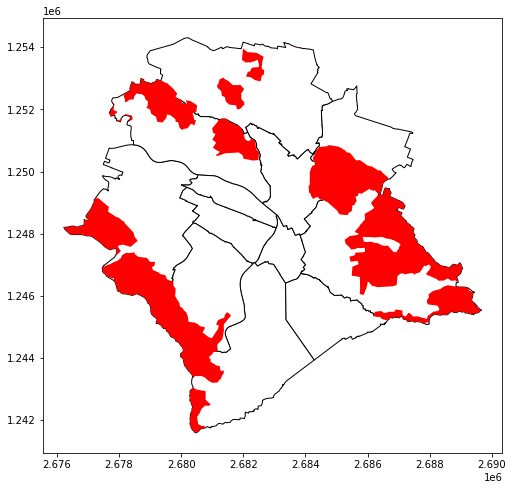

In [13]:
# ---------------------------------------------
# PART 3) DETERMINE THE FORESTS IN THE CITY OF ZURICH
# Intersect both objects and write the shapely geometry object to a new file
forests_within_zurich = united_districts.intersection(united_forests)
forests_area_ha = round(forests_within_zurich.area / 10000, 2)
print('Die Fläche des Waldes in Zürich beträgt {} ha.'.format(forests_area_ha))
write_geometries_to_files(forests_within_zurich, out_file_forests_in_zurich, out_driver, out_crs)

# Write the united geometry of Zurich to a file
write_geometries_to_files(united_districts, out_file_stadt_zuerich, out_driver, out_crs)

# Plot the results
show_map(map_layer_1=out_file_districts, map_layer_2=out_file_forests_in_zurich)
print('Done.')

## Aufgabe 2 (optional)
Berechnen Sie für jeden Stadtkreis deren Waldfläche mit einer geeigneten Shapely-Methode und speichern Sie diese Information als neues Attribut direkt ins File mit den Stadtkreisen. Beachten Sie, dass Sie hierfür das Schema anpassen müssen. 

# Erkenntnisse

Mit grosser Wahrscheinlichkeit beinhaltete die heutige Übung viel Neues für Sie. Welche Parameter konnten Sie modellieren, welche nicht? Notieren Sie im anschliessenden Feld Ihre wichtigsten Erkenntnisse von heute:

*[Ihre Notizen]*

# Projekt
Arbeiten Sie am Projekt weiter und wenden Sie das, was Sie heute gelernt haben, auf Ihr Projekt an. Bereiten Sie die Daten so vor, dass wir nächste Woche mit der vektorbasierten Datenverarbeitung beginnen können. Bestimmen Sie zudem alle Referenzsysteme Ihrer Daten – es kann nämlich vorkommen, dass die Daten in unterschiedlichen Referenzsystemen gespeichert sind. 